# Consolidate books dataset with information from ratings dataset

## 0. Set up

Libraries

In [149]:
# pip install -r requirements.txt

In [150]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.ticker as mtick

import re
import datetime

# EDA functions
from EDA_functions import ratings_cleaning_steps
from EDA_functions import folders_set_up
from EDA_functions import books_cleaning_steps
from NLP_preprocessing import identify_language

# import requests
# from bs4 import BeautifulSoup
# from PIL import Image
# from io import BytesIO

Project folder

In [152]:
github_folder, input_folder, output_folder = folders_set_up.generate_folders()

## 1. Import data

In [153]:
ratings_info = pd.read_csv(os.path.join(output_folder, "book_ratings_info.csv"))
ratings_info.shape

(212404, 11)

In [154]:
ratings_info.head()

,Title,reviews number,average rating,median rating,reviews with missing price,average price,median price,percentage missing prices,min review date,max review date,weighted rating
0,""" Film technique, "" and, "" Film acting """,2,4.500,4.5,2.0,NaN,NaN,1.0,2000-02-05,2009-08-20,4.292834
1,""" We'll Always Have Paris"": The Definitive Gui...",2,5.000,5.0,2.0,NaN,NaN,1.0,2004-03-28,2007-12-27,4.336313
2,"""... And Poetry is Born ..."" Russian Classical...",1,4.000,4.0,1.0,NaN,NaN,1.0,2010-09-20,2010-09-20,4.260690
3,"""A Titanic hero"" Thomas Andrews, shipbuilder",8,4.875,5.0,8.0,NaN,NaN,1.0,1998-07-20,2000-09-25,4.439144
4,"""A Truthful Impression of the Country"": Britis...",1,4.000,4.0,0.0,70.27,70.27,0.0,2005-08-08,2005-08-08,4.260690


In [155]:
books = pd.read_csv(os.path.join(input_folder,"books_data_with_index.csv"))

books.shape

(212404, 11)

## 2. Merge datasets

In [156]:
full_df = pd.merge(
    books,
    ratings_info,
    on = 'Title',
    how = 'inner'
)

In [157]:
full_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,...,reviews number,average rating,median rating,reviews with missing price,average price,median price,percentage missing prices,min review date,max review date,weighted rating
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN,...,1,4.000000,4.0,1.0,NaN,NaN,1.0,1999-10-23 00:00:00,1999-10-23,4.260690
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,...,9,4.555556,5.0,9.0,NaN,NaN,1.0,2004-02-10,2009-01-06,4.357840
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,...,4,5.000000,5.0,0.0,19.40,19.40,0.0,2001-06-02,2010-12-08,4.389408
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,...,32,3.718750,5.0,0.0,10.95,10.95,0.0,2005-02-14,2006-07-01,3.938400
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN,...,1,5.000000,5.0,0.0,39.95,39.95,0.0,2008-02-04 00:00:00,2008-02-04 00:00:00,4.306145


In [158]:
full_df.shape

(212404, 21)

## 3. Clean dataset

### 3.1 Published date
This variable presents different issues:
- Date is recorded as yyyy or dd-mm-yyyy format. Therefore it is not possible to directly convert Published date into a datetime.
- Some entries contain unclear year, such as "19??"
- Some dates are missing

Below we first apply a function which converts into dates based on the format (yyyy, yyyy-mm-dd or yyyy-mm-dd). Missing values are dropped.

#### 3.1.1 Explore column

In [159]:
print(f"Number of books with NA date: {full_df['publishedDate'].isna().sum():,}")

Number of books with NA date: 25,305


In [160]:
print("Number of books with unclear date (e.g. 19??):")
print(full_df['publishedDate'].astype(str).str.contains('\?', na=False).sum())

Number of books with unclear date (e.g. 19??):
128


In [161]:
# % of books with unclear date
(full_df['publishedDate'].isna().sum() + full_df['publishedDate'].astype(str).str.contains('\?', na=False).sum())/full_df.shape[0]

0.1197387996459577

In [162]:
# Inspect date for non missing values
full_df[~full_df['publishedDate'].isna()]['publishedDate'].sort_values()

157800     101-01-01
205865     101-01-01
160025     101-01-01
117218     101-01-01
56069      101-01-01
             ...    
96585           2025
98662     2030-12-31
191818          20??
63779           20??
125944          20??
Name: publishedDate, Length: 187099, dtype: object

#### 3.1.2 Apply function for extract year

In [163]:
# Apply function
full_df['date'] = full_df['publishedDate'].apply(books_cleaning_steps.datetime_conversion)

In [164]:
# Explore result
full_df[['publishedDate', 'date']].sort_values(by = 'publishedDate', ascending=False)

,publishedDate,date
63779,20??,NaT
191818,20??,NaT
125944,20??,NaT
98662,2030-12-31,2030-12-31
146995,2025,2025-01-01
...,...,...
212388,NaN,NaT
212391,NaN,NaT
212393,NaN,NaT
212395,NaN,NaT


In [165]:
# Generate year variable
full_df['year'] = full_df['date'].dt.year

In [166]:
# How many books have published date after July 2014?
full_df[full_df['date'] >= '2014-07-31'].count()

Title                         24760
description                   23718
authors                       24430
image                         23784
previewLink                   24761
publisher                     21382
publishedDate                 24761
infoLink                      24761
categories                    21131
ratingsCount                   6780
index                         24761
reviews number                24761
average rating                24761
median rating                 24761
reviews with missing price    24761
average price                  4697
median price                   4697
percentage missing prices     24761
min review date               24761
max review date               24761
weighted rating               24761
date                          24761
year                          24761
dtype: int64

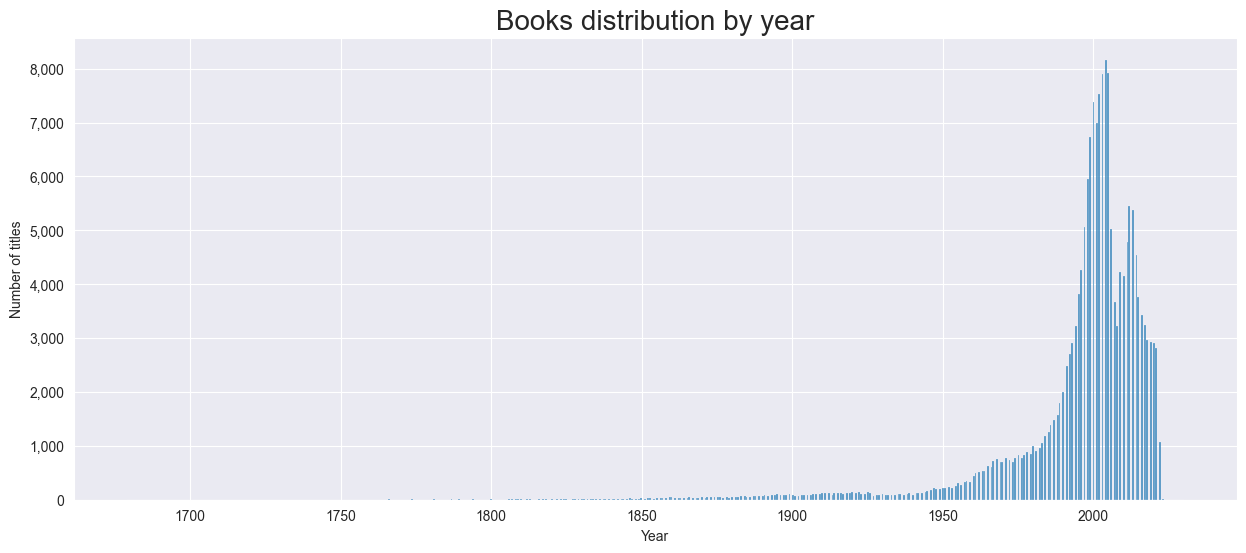

In [167]:
# Set style to darkgrid
sns.set_style("darkgrid")

# Draw histogram using Seaborn
plt.figure(
    figsize = (15, 6))

sns.histplot(
    data = full_df,
    x = 'year'
)

plt.xlabel('Year')
plt.ylabel('Number of titles')
plt.title('Books distribution by year', size = 20)

# Get the current axis
ax = plt.gca()

# Apply thousand separator to y-axis ticks
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

plt.savefig(os.path.join(output_folder, 'Charts', '02 Published date.png'))

In [168]:
full_df['year'].median()

2002.0

### 3.2 Categories

In [169]:
full_df['categories'].nunique()

10883

### 3.3 Description
Get description language

In [170]:
full_df["description_language"] = full_df["description"].map(identify_language, na_action='ignore')

In [171]:
print(f'Description in English: {full_df[full_df["description_language"]=="English"]["description_language"].count()}')
print(f'Description not in English: {full_df[full_df["description_language"]!="English"]["index"].count()}')

Description in English: 141755
Description not in English: 70649


In [172]:
# Keep books with english description
full_df = full_df[full_df["description_language"]=="English"]
print(f"Total after cleaning: {full_df.shape[0]}")

Total after cleaning: 141755


In [173]:
# Save dataset
full_df.to_csv(
    path_or_buf = os.path.join(output_folder, "English_fiction_pre_PCA.csv"),
    index = False
)

### 3.4 Clean dataset

##### Categories

In [174]:
# Get initial numbers
print(f"NA categories {full_df[full_df['categories'].notna()]['categories'].count()}")
print(f"Non NA categories {full_df[full_df['categories'].isna()]['index'].count()}")

NA categories 135982
Non NA categories 5773


In [175]:
# Keep those rows with English description
clean_df = full_df[full_df['categories'].notna()]

clean_df["categories"] = clean_df["categories"].str.lower()

print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 135982


/var/folders/1z/cxkb68zj6_s08n7300y_mzm00000gn/T/ipykernel_1632/1018592307.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["categories"] = clean_df["categories"].str.lower()


In [176]:
# Get initial numbers
print(f"Fiction books: {clean_df[clean_df['categories'].str.contains('fiction') & ~clean_df['categories'].str.contains('nonfiction')]['index'].count()}")
print(f"Non-ction books: {clean_df[~(clean_df['categories'].str.contains('fiction') & ~clean_df['categories'].str.contains('nonfiction'))]['index'].count()}")

Fiction books: 29412
Non-ction books: 106570


In [177]:
# Keep fiction books
clean_df = clean_df[clean_df['categories'].str.contains('fiction') & ~clean_df['categories'].str.contains('nonfiction')]
print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 29412


#### Date

In [178]:
# Get initial numbers
print(f"Books with no date: {clean_df[clean_df['date'].notna()]['index'].count()}")
print(f"Books with no date: {clean_df[clean_df['date'].isna()]['index'].count()}")

Books with no date: 29313
Books with no date: 99


In [179]:
clean_df = clean_df[clean_df["date"].notna()]
print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 29313


In [180]:
# Look at how many observations we have left
clean_df["categories"].value_counts()

categories
['fiction']                   21795
['juvenile fiction']           6509
['young adult fiction']         590
['american fiction']             67
['fantasy fiction']              44
                              ...  
['bengali fiction']               1
['colombian fiction']             1
['suspense fiction']              1
['argentine fiction']             1
['latin american fiction']        1
Name: count, Length: 79, dtype: int64

In [181]:
# Look at which variables still have NAs
clean_df.isna().sum()

Title                             0
description                       0
authors                         199
image                           718
previewLink                       0
publisher                      1801
publishedDate                     0
infoLink                          0
categories                        0
ratingsCount                  13661
index                             0
reviews number                    0
average rating                    0
median rating                     0
reviews with missing price        0
average price                 23962
median price                  23962
percentage missing prices         0
min review date                   0
max review date                   0
weighted rating                   0
date                              0
year                              0
description_language              0
dtype: int64

#### Author

In [182]:
# Get initial numbers
print(f"Books with no author: {clean_df[clean_df['authors'].isna()]['index'].count()}")
print(f"Books with author: {clean_df[clean_df['authors'].notna()]['index'].count()}")

Books with no author: 199
Books with author: 29114


In [183]:
# Remove entries with no publisher and those with no author
clean_df = clean_df[clean_df['authors'].notna()]
print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 29114


In [184]:
# Look at which variables still have NAs
clean_df.isna().sum()

Title                             0
description                       0
authors                           0
image                           718
previewLink                       0
publisher                      1772
publishedDate                     0
infoLink                          0
categories                        0
ratingsCount                  13563
index                             0
reviews number                    0
average rating                    0
median rating                     0
reviews with missing price        0
average price                 23793
median price                  23793
percentage missing prices         0
min review date                   0
max review date                   0
weighted rating                   0
date                              0
year                              0
description_language              0
dtype: int64

#### Publisher

In [185]:
# Get initial numbers
print(f"Books with no publisher: {clean_df[clean_df['publisher'].isna()]['index'].count()}")
print(f"Books with publisher: {clean_df[clean_df['publisher'].notna()]['index'].count()}")

Books with no publisher: 1772
Books with publisher: 27342


In [186]:
# Remove entries with no publisher and those with no author
clean_df = clean_df[clean_df['publisher'].notna()]
print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 27342


#### Image

In [189]:
# Get initial numbers
print(f"Books with image: {clean_df[clean_df['image'].notna()]['index'].count()}")
print(f"Books with no image: {clean_df[clean_df['image'].isna()]['index'].count()}")

Books with image: 26774
Books with no image: 568


In [190]:
# Keep only those books for which we have a book cover
clean_df = clean_df[clean_df['image'].notna()]
print(f"Total after cleaning: {clean_df.shape[0]}")

Total after cleaning: 26774


In [187]:
# Look at which variables still have NAs
clean_df.isna().sum()

Title                             0
description                       0
authors                           0
image                           568
previewLink                       0
publisher                         0
publishedDate                     0
infoLink                          0
categories                        0
ratingsCount                  12341
index                             0
reviews number                    0
average rating                    0
median rating                     0
reviews with missing price        0
average price                 22483
median price                  22483
percentage missing prices         0
min review date                   0
max review date                   0
weighted rating                   0
date                              0
year                              0
description_language              0
dtype: int64

In [188]:
clean_df.shape

(27342, 24)

We are left with 26 thousands books with no missing values for the variables of interest

#### Save dataset

In [ ]:
# Keep only relevant columns
clean_df = clean_df[['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'infoLink', 'categories', 'index',
       'reviews number', 'average rating', 'median rating',
       'min review date', 'max review date',
       'weighted rating', 'date', 'year', 'description_language']]

In [ ]:
clean_df.to_csv(
    path_or_buf = os.path.join(output_folder, "English_fiction_pre_PCA_3.csv"),
    index = False
)

In [ ]:
clean_df.shape

## 4. Feature engineering

### 4.1 Book description PCA

In [ ]:
#clean_df = pd.read_csv("English_fiction_pre_PCA_3.csv")

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
# Create bag of words
#create_BOW_feature_for_english_descriptions(clean_df, "description", "english_BOW")

In [ ]:
#pca_model = add_TFIDF_PCA_to_df(clean_df, "english_BOW", 0.95)

### 4.2 Popularity
Calculate an alternative target variable that captures the number of reviews that the book received between its publication date and when the reviews were collected (July 2014)  
Note: this is still WIP as some publish dates are above July 2014 (and even 2024!) and the calculations don't work

In [ ]:
# Create column with July 2014 date
full_df['review_collection_date'] = pd.to_datetime('31/07/2014', format="%d/%m/%Y")

In [ ]:
# Calculate number of days between published date and review collection date
#full_df['days_of_book_available'] = (full_df['review_collection_date'] - full_df['date']).dt.days

In [ ]:
# Calculate number of reviews per daya
#full_df['reviews_number_per_day'] = full_df['reviews number']/full_df['days_of_book_available']